In [1]:
# !pip install fbprophet

In [2]:
from matplotlib import pyplot as plt
import pandas as pd

## 데이터 로드

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/data/미스터리튜브_stat.csv'
df = pd.read_csv(path, header=0)
print(df.shape)
print(df.head())

(369, 6)
   searchDate  dailyViewCount  ...  favorablePercent  activePercent
0  2020-02-14           19743  ...                 0             54
1  2020-02-15           23929  ...                 0             57
2  2020-02-16           26015  ...                 0             58
3  2020-02-17           25312  ...                 0             58
4  2020-02-18           25040  ...                 0             57

[5 rows x 6 columns]


## 불필요한 컬럼 삭제(단변량 예측)

In [4]:
del df['dailyViewCount']
del df['videoCount']
del df['favorablePercent']
del df['activePercent']

In [5]:
# 데이터의 마지막 날짜와 그 다음 날짜를 저장
lastday = df['searchDate'][len(df)-1]
nextday = str(pd.date_range(lastday, periods=2)[1])[:10]
print("마지막 날짜 : {}, 예측 시작 날짜 : {}".format(lastday, nextday))

마지막 날짜 : 2021-02-16, 예측 시작 날짜 : 2021-02-17


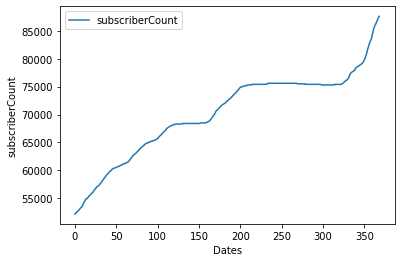

In [6]:
df.plot()
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.show()

## 모델에 맞게 데이터 전처리

In [7]:
# 컬럼명 변경
df.columns = ['ds', 'y']
# 데이터 타입 변경
df['ds']= pd.to_datetime(df['ds'])

In [8]:
preday = 30

In [9]:
fast_10day = str(pd.date_range(df['ds'][len(df)-preday], periods=preday)[0])[:10]

In [10]:
y_true = df['y'][-preday:].values

# train set 마지막 preday일 날짜 예측 검증
last_10day = list()
for i in range(preday):
    last_10day.append(str(pd.date_range(fast_10day, periods=preday)[i])[:10])
last_10day = pd.DataFrame(last_10day, columns = ['ds'])
last_10day['ds']= pd.to_datetime(last_10day['ds'])

In [11]:
from fbprophet import Prophet

# 모델 생성
model = Prophet()
# 모델 학습
model.fit(df)

forecast = model.predict(last_10day)
y_pred = forecast['yhat'].values

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


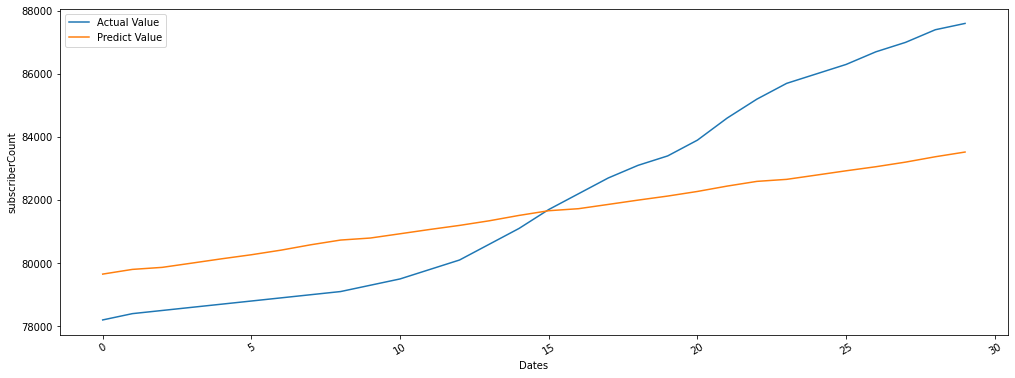

In [12]:
plt.figure(figsize=(17,6))
plt.plot(y_true, label="Actual Value")
plt.plot(y_pred, label="Predict Value")
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.xticks(rotation = 30)
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print('prophet - MAE 값 : %.3f' % mae)

prophet - MAE 값 : 1832.925


## 예측할 일 수 입력

In [14]:
# 예측할 날짜 일 수
predict_day = 9
# 예측 날짜 문자열 리스트 생성
pred_date = list()
for i in range(predict_day):
    pred_date.append(str(pd.date_range(nextday, periods=predict_day)[i])[:10])

# 날짜 리스트를 데이터 프레임 화
pred_date = pd.DataFrame(pred_date, columns = ['ds'])
# 문자열을 날짜 데이터 형식으로 변환
pred_date['ds']= pd.to_datetime(pred_date['ds'])

## 시각화

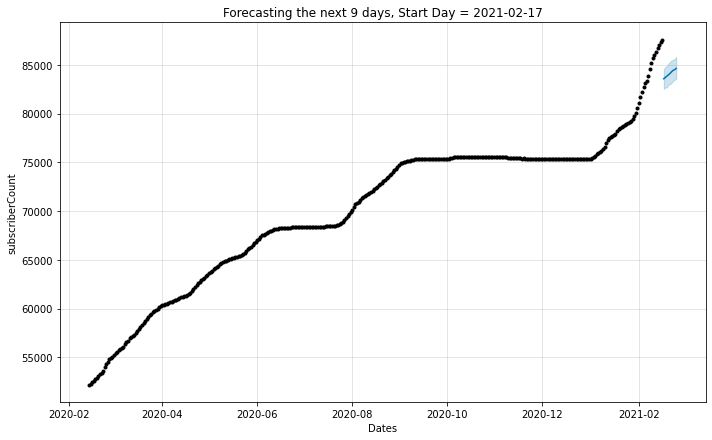

In [15]:
# 미래 예측
forecast = model.predict(pred_date)
model.plot(forecast)
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {predict_day} days, Start Day = {nextday}")
plt.show()

In [27]:
# 기존 데이터 마지막 날의 다음 날을 구함(= 미래 예측 데이터의 시작 날짜)
next = str(pd.date_range(df['ds'][len(df)-1], periods=2)[1])[:10]

step = 9
# 예측 데이터 날짜 리스트 생성
forecast_date = []
for i in range(step):
  forecast_date.append(str(pd.date_range(next, periods=step)[i])[:10])

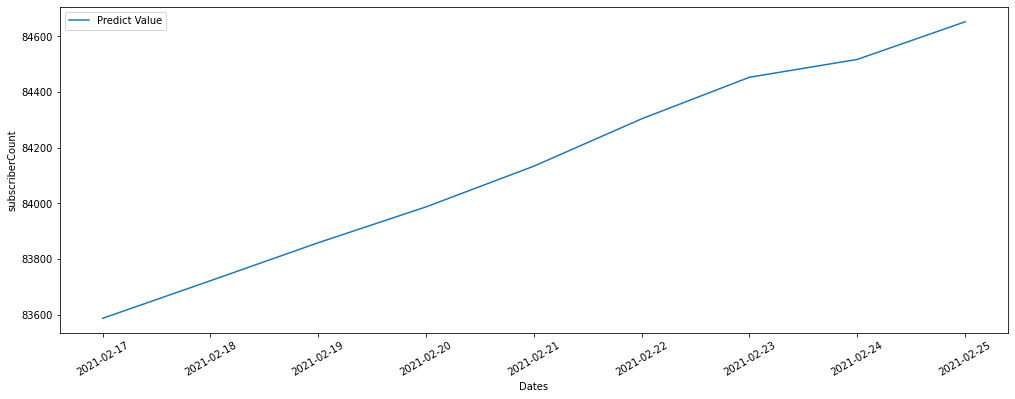

In [28]:
plt.figure(figsize=(17,6))
plt.plot(forecast['yhat'], label="Predict Value")
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.xticks(list(range(step)), forecast_date, rotation = 30)
plt.legend()
plt.show()

In [16]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-17,83607.734713,82532.390137,84606.007152,83607.734713,83607.734713,-20.902266,-20.902266,-20.902266,-20.902266,-20.902266,-20.902266,0.0,0.0,0.0,83586.832447
1,2021-02-18,83740.604863,82707.028054,84775.459659,83740.604863,83740.604863,-18.602286,-18.602286,-18.602286,-18.602286,-18.602286,-18.602286,0.0,0.0,0.0,83722.002577
2,2021-02-19,83873.475012,82672.213594,84898.328283,83873.475012,83873.475012,-15.013516,-15.013516,-15.013516,-15.013516,-15.013516,-15.013516,0.0,0.0,0.0,83858.461496
3,2021-02-20,84006.345162,82977.470072,85152.940441,84005.143645,84012.412550,-19.150311,-19.150311,-19.150311,-19.150311,-19.150311,-19.150311,0.0,0.0,0.0,83987.194850
4,2021-02-21,84139.215311,83021.397249,85309.709522,84129.167718,84159.079199,-5.750988,-5.750988,-5.750988,-5.750988,-5.750988,-5.750988,0.0,0.0,0.0,84133.464324
5,2021-02-22,84272.085461,83163.948299,85475.512190,84244.644629,84303.472135,31.478257,31.478257,31.478257,31.478257,31.478257,31.478257,0.0,0.0,0.0,84303.563718
6,2021-02-23,84404.955610,83367.999961,85545.853824,84355.263487,84454.927125,47.941111,47.941111,47.941111,47.941111,47.941111,47.941111,0.0,0.0,0.0,84452.896721
7,2021-02-24,84537.825760,83461.018026,85616.666220,84466.604471,84610.549738,-20.902266,-20.902266,-20.902266,-20.902266,-20.902266,-20.902266,0.0,0.0,0.0,84516.923493
8,2021-02-25,84670.695909,83577.969655,85831.794747,84573.236127,84770.558926,-18.602286,-18.602286,-18.602286,-18.602286,-18.602286,-18.602286,0.0,0.0,0.0,84652.093623


In [17]:
# yhat은 미래 예측 값, yhat_lower은 예측 하한값, yhat_upper은 예측 상한값
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

          ds          yhat    yhat_lower    yhat_upper
0 2021-02-17  83586.832447  82532.390137  84606.007152
1 2021-02-18  83722.002577  82707.028054  84775.459659
2 2021-02-19  83858.461496  82672.213594  84898.328283
3 2021-02-20  83987.194850  82977.470072  85152.940441
4 2021-02-21  84133.464324  83021.397249  85309.709522
5 2021-02-22  84303.563718  83163.948299  85475.512190
6 2021-02-23  84452.896721  83367.999961  85545.853824
7 2021-02-24  84516.923493  83461.018026  85616.666220
8 2021-02-25  84652.093623  83577.969655  85831.794747
